In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    return mask

def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
    return image, mask

def preprocess(image, mask):
    image = tf.image.resize(image, (128, 128), method="nearest")
    mask = tf.image.resize(mask, (128, 128), method="nearest")
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    return image, mask

def create_dataset(image_dir, mask_dir, batch_size, image_size, augment_data=False):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    
    def load_and_preprocess(image_path, mask_path):
        image = load_image(image_path)
        mask = load_mask(mask_path)
        image, mask = preprocess(image, mask)
        if augment_data:
            image, mask = augment(image, mask)
        return image, mask
    
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

train_image_dir = '/path/to/the/data'
train_mask_dir = '/path/to/the/data'
test_image_dir = '/path/to/the/data'
test_mask_dir = '/path/to/the/data'

batch_size = 8
image_size = (128, 128)
augment_data = True
dataset = create_dataset(train_image_dir, train_mask_dir, batch_size, image_size, augment_data=augment_data)

dataset_size = len(os.listdir(train_image_dir))
validation_split = 0.2
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

train_dataset = dataset.take(train_size // batch_size)
val_dataset = dataset.skip(train_size // batch_size).take(val_size // batch_size)

test_dataset = create_dataset(test_image_dir, test_mask_dir, batch_size, image_size)

# U-Net architecture
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model():
    inputs = layers.Input(shape=(128, 128, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

epochs = 1

model = build_unet_model()
model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


2024-08-01 14:08:07.863827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 14:08:07.872601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 14:08:07.881396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 14:08:07.884054: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 14:08:07.891487: I tensorflow/core/platform/cpu_feature_guar

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


I0000 00:00:1722542893.596293   95255 service.cc:146] XLA service 0x76b6a801cd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722542893.596330   95255 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-08-01 14:08:13.667118: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-01 14:08:16.697134: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-08-01 14:08:51.897559: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packag

   2/1055 ━━━━━━━━━━━━━━━━━━━━ 1:13 70ms/step - accuracy: 0.5494 - loss: 0.4266   

I0000 00:00:1722542933.033633   95255 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 132s 85ms/step - accuracy: 0.7118 - loss: 0.2753 - val_accuracy: 0.7177 - val_loss: 0.2701
Epoch 2/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 83s 78ms/step - accuracy: 0.7171 - loss: 0.2702 - val_accuracy: 0.7121 - val_loss: 0.2747
Epoch 3/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 87s 82ms/step - accuracy: 0.7154 - loss: 0.2715 - val_accuracy: 0.7131 - val_loss: 0.2741
Epoch 4/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 87s 81ms/step - accuracy: 0.7151 - loss: 0.2721 - val_accuracy: 0.7151 - val_loss: 0.2718
Epoch 5/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 86s 81ms/step - accuracy: 0.7167 - loss: 0.2707 - val_accuracy: 0.7211 - val_loss: 0.2669
Epoch 6/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 87s 81ms/step - accuracy: 0.7157 - loss: 0.2714 - val_accuracy: 0.7191 - val_loss: 0.2688
Epoch 7/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 87s 82ms/step - accuracy: 0.7175 - loss: 0.2705 - val_accuracy: 0.7222 - val_loss: 0.2658
Epoch 8/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 84s 79ms/step - accuracy: 0.7154 - lo

Epoch 50/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 87s 81ms/step - accuracy: 0.7157 - loss: 0.2718 - val_accuracy: 0.7170 - val_loss: 0.2707
Epoch 51/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 87s 82ms/step - accuracy: 0.7152 - loss: 0.2722 - val_accuracy: 0.7154 - val_loss: 0.2725
Epoch 52/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 85s 79ms/step - accuracy: 0.7153 - loss: 0.2717 - val_accuracy: 0.7132 - val_loss: 0.2745
Epoch 53/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 88s 83ms/step - accuracy: 0.7149 - loss: 0.2721 - val_accuracy: 0.7188 - val_loss: 0.2687
Epoch 54/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 88s 83ms/step - accuracy: 0.7151 - loss: 0.2724 - val_accuracy: 0.7149 - val_loss: 0.2733
Epoch 55/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 88s 83ms/step - accuracy: 0.7170 - loss: 0.2705 - val_accuracy: 0.7175 - val_loss: 0.2693
Epoch 56/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 89s 84ms/step - accuracy: 0.7158 - loss: 0.2716 - val_accuracy: 0.7185 - val_loss: 0.2686
Epoch 57/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 88s 83ms/step - ac

Epoch 99/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 76s 70ms/step - accuracy: 0.7148 - loss: 0.2730 - val_accuracy: 0.7130 - val_loss: 0.2744
Epoch 100/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 83s 77ms/step - accuracy: 0.7168 - loss: 0.2708 - val_accuracy: 0.7180 - val_loss: 0.2697
Epoch 101/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 85s 79ms/step - accuracy: 0.7171 - loss: 0.2704 - val_accuracy: 0.7134 - val_loss: 0.2742
Epoch 102/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 87s 82ms/step - accuracy: 0.7112 - loss: 0.2763 - val_accuracy: 0.7190 - val_loss: 0.2686
Epoch 103/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 87s 82ms/step - accuracy: 0.7202 - loss: 0.2679 - val_accuracy: 0.7181 - val_loss: 0.2693
Epoch 104/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 87s 81ms/step - accuracy: 0.7185 - loss: 0.2690 - val_accuracy: 0.7172 - val_loss: 0.2705
Epoch 105/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 86s 81ms/step - accuracy: 0.7154 - loss: 0.2721 - val_accuracy: 0.7159 - val_loss: 0.2723
Epoch 106/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 87s 81ms/st

E0000 00:00:1722555994.887587   95254 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722555995.067707   95254 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722555995.241603   95254 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722555995.429616   95254 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722555995.617695   95254 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-

628/628 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8463 - loss: 0.1467
Test Loss: 0.14821653068065643
Test Accuracy: 0.8443222641944885


628/628 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step


W0000 00:00:1722556011.103865   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.118023   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.125288   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.129870   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.130230   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.130616   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.131012   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.131398   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.131760   95165 gp

W0000 00:00:1722556011.512084   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.519439   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.526816   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.534112   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.541385   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.548739   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.556048   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.563442   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556011.570834   95165 gp

W0000 00:00:1722556012.333242   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.340968   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.348574   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.356293   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.363901   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.371627   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.379316   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.387000   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.394842   95165 gp

W0000 00:00:1722556012.955817   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.969994   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.984024   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556012.998200   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.012374   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.026461   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.040655   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.054931   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.069012   95165 gp

W0000 00:00:1722556013.574290   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.575274   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.575879   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.576480   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.576995   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.577650   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.578239   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.578850   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.579374   95165 gp

W0000 00:00:1722556013.987718   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556013.995193   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.002913   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.010948   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.019082   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.026714   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.034348   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.042031   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.049685   95165 gp

W0000 00:00:1722556014.822199   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.830039   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.837876   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.845845   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.850406   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.851782   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.852989   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.854276   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556014.855525   95165 gp

W0000 00:00:1722556015.226227   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556015.234260   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556015.242313   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556015.250233   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556015.258195   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556015.266296   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556015.274381   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556015.282408   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556015.290491   95165 gp

W0000 00:00:1722556016.051857   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556016.066437   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556016.080845   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556016.095413   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556016.110181   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556016.125167   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556016.140259   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556016.154976   95165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722556016.169609   95165 gp

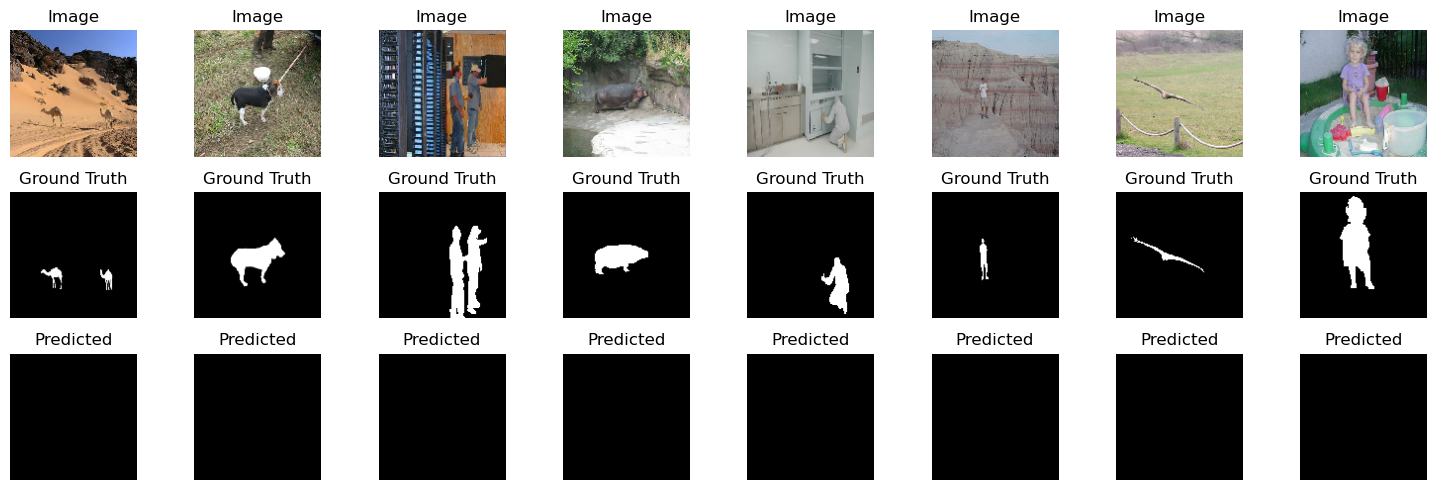

In [2]:
import matplotlib.pyplot as plt
import numpy as np

predictions = model.predict(test_dataset)

def visualize_predictions(images, masks, outputs):
    images = images.numpy() 
    masks = masks.numpy()   
    outputs = tf.sigmoid(outputs).numpy() 

    num_images = len(images)
    fig, axs = plt.subplots(3, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Original Image
        axs[0, i].imshow(images[i])
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')
        
        # Ground Truth Mask
        axs[1, i].imshow(masks[i, :, :, 0], cmap='gray')
        axs[1, i].set_title('Ground Truth')
        axs[1, i].axis('off')
        
        # Predicted Mask
        axs[2, i].imshow(outputs[i, :, :, 0], cmap='gray')
        axs[2, i].set_title('Predicted')
        axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

loss_fn = tf.keras.losses.MeanAbsoluteError()

tf.random.set_seed(42)

for images, masks in test_dataset.take(1):  
    outputs = model(images, training=False)  
    loss = loss_fn(masks, outputs)

    visualize_predictions(images, masks, outputs)
    break  
